# Predicting GOES XRS Light Curves Using Random Forest Regresssion

In this notebook, we create plots of the light curves with the predicted remaining duration of a given flare.  This can be used for any event in the data set, in both GOES/XRS channels.

In [1]:
import warnings
import datetime

from matplotlib import pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap
import numpy as np
import astropy.time
import astropy.units as u
import astropy.table
from sunpy.time import parse_time
from sunpy import timeseries
from sunpy.net import Fido, attrs as a
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
import h5py
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

In [2]:
cmap_goes = ListedColormap(['cornflowerblue', 'lightcoral'], N=2)
cmap_goes2 = ListedColormap(['blue', 'red'], N=2)

In [3]:
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['grid.linestyle'] = ':'

## Querying GOES Data 

First, we create an example lightcurve from the 5-November-2013 X-flare that is used to state the problem.  Given the lightcurve up to a certain time, in this instance, until UT22:14, can we predict the remaining duration of the flare?

The first step is to download the GOES/XRS data.  We also remove the SWPC scaling factors from the data, since SunPy (at the time of writing) uses a slightly older version of the data that still includes the factors in GOES-15 data.  See https://satdat.ngdc.noaa.gov/sem/goes/data/science/xrs/GOES_13-15_XRS_Science-Quality_Data_Readme.pdf for more information.

In [4]:
## Download the GOES timeseries data:
result = Fido.search(
    a.Time('2013/11/04 06:00', '2013/11/06 00:00'),
    a.Instrument.xrs,
) 
files = Fido.fetch(result)

goes = timeseries.TimeSeries(files, concatenate=True, ) 
goes = goes.truncate('2013-11-05 22:00','2013-11-05 23:00')

/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3

The data queried here, from NASA, include scaling factors on GOES-15 data, that have since been deprecated by NOAA.
These columns are rescaled to remove these SWPC scaling factors.
See https://satdat.ngdc.noaa.gov/sem/goes/data/science/xrs/GOES_13-15_XRS_Science-Quality_Data_Readme.pdf for more information.

In [5]:
scale_xrsb = 1.0/0.7
scale_xrsa = 1.0/0.85

In [6]:
goes.to_dataframe()['xrsa'] *= scale_xrsa
goes.to_dataframe()['xrsb'] *= scale_xrsb

In [7]:
goes = goes.add_column('xrsa_deriv',
                       savgol_filter(goes.to_dataframe()['xrsa'], 7, 4, deriv=1) * goes.units['xrsa'] / u.s)
goes = goes.add_column('xrsb_deriv',
                       savgol_filter(goes.to_dataframe()['xrsb'], 7, 4, deriv=1) * goes.units['xrsb'] / u.s)

/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)


In [8]:
goes_data = goes.to_table()
goes_data['date'] = astropy.time.Time(goes_data['date'])
goes_data['time'] = (goes_data['date'] - goes_data['date'][0]).to('s')
# Truncated data used to show the lightcurve up until 22:14:
goes_trunc = goes.truncate('2013-11-05 22:00','2013-11-05 22:14')
goes_trunc_data = goes_trunc.to_table()
goes_trunc_data['date'] = astropy.time.Time(goes_trunc_data['date'])
goes_trunc_data['time'] = (goes_trunc_data['date'] - goes_trunc_data['date'][0]).to('s')

/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)


## Calculating Time Periods

Next, we calculate the t_i values defined in the paper.  These are five time periods, defined in terms of the first derivative of the XRS data, that we use to measure the feature of an event.

t0 is roughly the start time of the event.  
t1 is the peak of the first derivative.  
t2 is the peak of the event.  
t3 is the minimum of the first derivative.  
t4 is roughly the end time of the event.

In [9]:
t0 = np.where(goes_data['xrsb_deriv'] > np.max(goes_data['xrsb'])/1e4)[0][0]
t1 = np.where(goes_data['xrsb_deriv'] == np.max(goes_data['xrsb_deriv']))[0][0]
t2 = np.where(goes_data['xrsb'] == np.max(goes_data['xrsb']))[0][0]
t3 = np.where(goes_data['xrsb_deriv'] == np.min(goes_data['xrsb_deriv']))[0][0]
temp_deriv = np.copy(goes_data['xrsb_deriv'])
temp_deriv[np.logical_or(goes_data['xrsb_deriv'] >= 0.0,
                         np.indices(goes_data['xrsb_deriv'].shape) <= t3)[0]] = -1e100
t4 = np.where(temp_deriv > (-1.0) * np.max(goes_data['xrsb'])/1e4)[0][0]

Finally, we plot the light curve and its time derivative.  This is used in Figure 1 in the paper to state the problem: can we predict how long it will take for a flare to return to background level?

Text(0.5, 1, 'GOES Class X5.4')

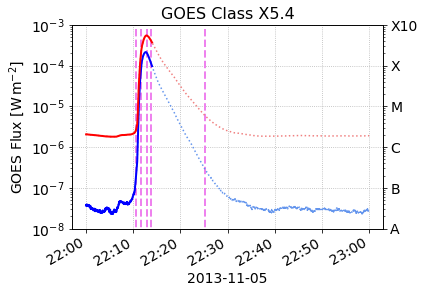

In [10]:
fig = plt.figure()
ax = fig.gca()
goes.to_dataframe()[['xrsa','xrsb']].plot(ax=ax, ls=':', colormap=cmap_goes,legend=False)
goes_trunc.to_dataframe()[['xrsa','xrsb']].plot(ax=ax, lw=2, colormap=cmap_goes2, legend=False)
plt.grid(True,which='major',axis='both',linestyle=':')
# Plot vertical lines
ax.vlines(goes.index[[t0, t1, t2, t3, t4]], 0, 1e-3, ls='--', color='violet', lw=2)
# Format y-axis
ax.set_yscale('log')
ax.set_ylim(1e-8, 1e-3)
ax.set_ylabel(f'GOES Flux [{goes.units["xrsa"].to_string(format="latex_inline")}]',)
# Add flare classifcation axis
ax2 = ax.twinx()
ax2.set_yscale("log")
ax2.set_ylim(1e-8, 1e-3)
ax2.set_yticks((1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3))
ax2.set_yticklabels(('A', 'B', 'C', 'M', 'X', 'X10'),)
# Format x-axis
formatter = matplotlib.dates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(formatter)
ax.set_xlabel(goes.index[0].strftime('%Y-%m-%d'))
# Save
plt.tight_layout()
ax.set_title('GOES Class X5.4')
#plt.savefig('truncated_flare.eps',format='eps',dpi=300)

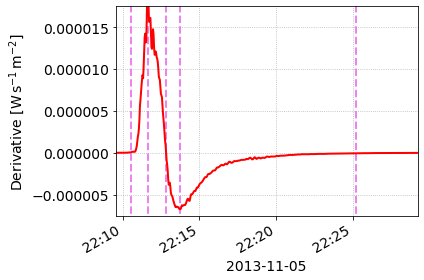

In [11]:
fig = plt.figure()
ax = fig.gca()

ts = goes.to_dataframe()['xrsb_deriv']
ts.plot(ax=ax, legend=False, color='red', lw=2)
ax.vlines(goes.index[[t0, t1, t2, t3, t4]], -1, 1, ls='--', color='violet', lw=2)
ax.set_ylabel(f'Derivative [{goes.units["xrsb_deriv"].to_string(format="latex_inline")}]')
ax.set_ylim(-0.75e-5,1.75e-5)
ax.set_xlim(goes.index[t0] - datetime.timedelta(minutes=1),
            goes.index[t4] + datetime.timedelta(minutes=4))
ax.xaxis.set_major_formatter(formatter)
ax.set_xlabel(goes.index[0].strftime('%Y-%m-%d'))
plt.grid(True,which='major',axis='both',linestyle=':')
plt.tight_layout()
#plt.savefig('truncated_deriv.eps',format='eps',dpi=300)

## Duration Predictions

Now, we create predictions for the remaining duration of a set of flares ranging from small to large in class, and from short to long in duration.  First, we read in our database and train the random forest predictor.

In [12]:
## Read in the database
var_names = ([f'f{i}_18' for i in range(5)] + [f't{i}_18' for i in range(5)] + [f'a{i}_18' for i in range(5)] +
             [f'dfdt{i}_18' for i in range(5)] + [f'f{i}_054' for i in range(5)] + [f't{i}_054' for i in range(5)] +
             [f'a{i}_054' for i in range(5)] + [f'dfdt{i}_054' for i in range(5)] +
             ['ptd', 'temperature', 'em', 'start_time', 'end_time', 'fwhm18', 'decay18', 't_s18', 't_e18',
              'fwhm054', 'decay054', 't_s054', 't_e054',])
with h5py.File('goes15_recal.h5','r') as hf:
    data = {v: hf[v][:].squeeze() for v in var_names}


### Predicting $t_3$ and $t_4$ from $t_0,t_1,t_2$


We want to train the data using the features through time $t_2$ only and make predictions for $t_3$ and $t_4$

In [13]:
# Split data into training and test sets
#  and then train the random forest
## First train the data using the features through time t2 only and make predictions for t3 and t4
ind = np.arange(len(data['start_time']))  # This is for selecting out other entries corresponding to the train/test split.
var_names3 = [
    'f0_18', 'f1_18', 'f2_18', 't0_18', 't1_18', 't2_18',
    'a0_18', 'a1_18', 'a2_18', 'dfdt0_18', 'dfdt1_18', 'dfdt2_18',
    'f0_054', 'f1_054', 'f2_054', 't0_054', 't1_054', 't2_054',
    'a0_054', 'a1_054', 'a2_054', 'dfdt0_054', 'dfdt1_054', 'dfdt2_054',
]
features3 = np.array([data[v] for v in var_names3]).T
labels3 = np.array([data['t3_18'], data['t4_18'], data['t3_054'], data['t4_054']]).T

## Train-test split.  Currently using a reproducible split.  
#    Change random_state = None for truly random splits.
train_features, test_features, train_labels, test_labels, train_ind, test_ind = train_test_split(
    features3, labels3, ind, test_size = 0.33, random_state = 10)

# Create the random forest
rf_options = {
    'n_estimators': 1500,
    'max_features': 'auto',
    'min_samples_leaf': 1,
    'min_samples_split': 5,
    'max_depth': 10,
    'n_jobs': -1,
}

rf = RandomForestRegressor(**rf_options)

# Train the model on training data
rf.fit(train_features, train_labels)

# Use the forest's predict method on the test data
predictions = rf.predict(test_features)


## Calculate the uncertainties in the model by using the +- 1 and 2 sigma predictions
def pred_ints_vec(model, X, percentile=68.2):     
    Y = np.stack([pred.predict(X) for pred in model.estimators_])         
    err_down = np.percentile(Y, (100 - percentile) / 2., axis=0) 
    err_up = np.percentile(Y, 100 - (100 - percentile) / 2., axis=0) 
    return err_down, err_up

err_1s_down, err_1s_up = pred_ints_vec(rf,test_features)
err_2s_down, err_2s_up = pred_ints_vec(rf,test_features,percentile=95)



In [14]:
## Define a function to plot and predict the remaining duration for a given event defined by index in the 
##  test set.  Starts at time t2 and runs until t4.
def predict_and_plot_duration_t2(index, filename=None):
    ## First, retrieve the XRS data for the event:
    obs_start = datetime.datetime.strptime( str(data['start_time'][test_ind[index]]), "b'%d-%b-%y %H:%M:%S.%f'")
    obs_end = obs_start + datetime.timedelta(seconds=data['t_e18'][test_ind[index]]+2100)
    timeend = obs_start + datetime.timedelta(seconds=data['t_e18'][test_ind[index]])
    timenow18 = obs_start + datetime.timedelta(seconds=data['t2_18'][test_ind[index]])
    timenow054 = obs_start + datetime.timedelta(seconds=data['t2_054'][test_ind[index]])
    result = Fido.search(a.Time(obs_start, timeend), a.Instrument('xrs')) 
    files = Fido.fetch(result)
    obs_goes = timeseries.TimeSeries(files, concatenate=True) 
    obs_goes = obs_goes.truncate(obs_start,obs_end)
    goes_trunc18 = obs_goes.truncate(obs_start, timenow18)
    goes_trunc054 = obs_goes.truncate(obs_start, timenow054)
    obs_goes_data = obs_goes.to_dataframe()
    goes_trunc_data18 = goes_trunc18.to_dataframe()
    goes_trunc_data054 = goes_trunc054.to_dataframe()
    
    obs_goes_data['xrsb'] *= scale_xrsb 
    obs_goes_data['xrsa'] *= scale_xrsa
    goes_trunc_data18['xrsb'] *= scale_xrsb
    goes_trunc_data054['xrsa'] *= scale_xrsa

    ## Create a plot and plot the XRS data up until time t2
    figure = plt.figure()
    axes = plt.gca()
    dates = matplotlib.dates.date2num(parse_time(obs_goes_data.index).datetime)
    dates_trunc18 = matplotlib.dates.date2num(parse_time(goes_trunc_data18.index).datetime)
    dates_trunc054 = matplotlib.dates.date2num(parse_time(goes_trunc_data054.index).datetime)


    axes.plot_date(dates, obs_goes_data['xrsb'], ':',
                       label=r'1.0--8.0 $\AA$', color='black', lw=1)
    axes.plot_date(dates_trunc18, goes_trunc_data18['xrsb'], '-',
                       label=r'1.0--8.0 $\AA$', color='red', lw=1)

    axes.plot_date(dates, obs_goes_data['xrsa'], ':',
                       label=r'0.5--4.0 $\AA$', color='black', lw=1)
    axes.plot_date(dates_trunc054, goes_trunc_data054['xrsa'], '-',
                       label=r'0.5--4.0 $\AA$', color='blue', lw=1)

    ## Plot the predictions for the 1--8 Angstrom channel:
    plt.scatter(obs_start + datetime.timedelta(seconds=predictions[index,1]), data['f0_18'][test_ind[index]],\
             color='orangered', marker='X', lw=0.5)

    pred_t4 = matplotlib.dates.date2num(obs_start + datetime.timedelta(seconds=predictions[index,1]))

    interp_x = np.append(dates_trunc18, pred_t4)
    interp_y = np.append(goes_trunc_data18['xrsb'], data['f0_18'][test_ind[index]])
    interp_f = interp1d(interp_x, interp_y, kind='linear')
    xnew = np.linspace(interp_x[-2], interp_x[-1], num=100, endpoint=True)
    ynew = interp_f(xnew)

    axes.plot_date(xnew, ynew, '--', color='orangered',lw=1.25)
    
    ## Calculate the +- 1 and +-2 sigma uncertainties in the duration
    pred_t4_1sd = matplotlib.dates.date2num(obs_start + datetime.timedelta(seconds=err_1s_down[index,1]))
    pred_t4_1su = matplotlib.dates.date2num(obs_start + datetime.timedelta(seconds=err_1s_up[index,1]))

    ## Plot interpolated lines connecting t2 to the predicted uncertainties
    interp_x_1sd = np.append(dates_trunc18, pred_t4_1sd)
    interp_f_1sd = interp1d(interp_x_1sd, interp_y, kind='linear')
    x_1sd = np.linspace(interp_x_1sd[-2], interp_x_1sd[-1], num=100, endpoint=True)
    y_1sd = interp_f_1sd(x_1sd)
    axes.plot_date(x_1sd, y_1sd, '--', color='coral',lw=1)

    interp_x_1su = np.append(dates_trunc18, pred_t4_1su)
    interp_f_1su = interp1d(interp_x_1su, interp_y, kind='linear')
    x_1su = np.linspace(interp_x_1su[-2], interp_x_1su[-1], num=100, endpoint=True)
    y_1su = interp_f_1su(x_1su)
    axes.plot_date(x_1su, y_1su, '--', color='coral',lw=1)

    axes.plot_date([pred_t4_1sd,pred_t4_1su],
                   [data['f0_18'][test_ind[index]],data['f0_18'][test_ind[index]]],'-',color='coral')

    ## Repeat everything for the 0.5--4 A channel
    plt.scatter(obs_start + datetime.timedelta(seconds=predictions[index,3]), data['f0_054'][test_ind[index]],\
             color='blueviolet', marker='X', lw=0.5)

    pred_t4 = matplotlib.dates.date2num(obs_start + datetime.timedelta(seconds=predictions[index,3]))

    interp_x = np.append(dates_trunc054, pred_t4)
    interp_y = np.append(goes_trunc_data054['xrsa'], data['f0_054'][test_ind[index]])
    interp_f = interp1d(interp_x, interp_y, kind='linear')
    xnew = np.linspace(interp_x[-2], interp_x[-1], num=100, endpoint=True)
    ynew = interp_f(xnew)

    axes.plot_date(xnew, ynew, '--', color='blueviolet',lw=1.25)
                    
    pred_t4_1sd = matplotlib.dates.date2num(obs_start + datetime.timedelta(seconds=err_1s_down[index,3]))
    pred_t4_1su = matplotlib.dates.date2num(obs_start + datetime.timedelta(seconds=err_1s_up[index,3]))

    interp_x_1sd = np.append(dates_trunc054, pred_t4_1sd)
    interp_f_1sd = interp1d(interp_x_1sd, interp_y, kind='linear')
    x_1sd = np.linspace(interp_x_1sd[-2], interp_x_1sd[-1], num=100, endpoint=True)
    y_1sd = interp_f_1sd(x_1sd)
    axes.plot_date(x_1sd, y_1sd, '--', color='mediumslateblue',lw=1)

    interp_x_1su = np.append(dates_trunc054, pred_t4_1su)
    interp_f_1su = interp1d(interp_x_1su, interp_y, kind='linear')
    x_1su = np.linspace(interp_x_1su[-2], interp_x_1su[-1], num=100, endpoint=True)
    y_1su = interp_f_1su(x_1su)
    axes.plot_date(x_1su, y_1su, '--', color='mediumslateblue',lw=1)

    axes.plot_date([pred_t4_1sd,pred_t4_1su],
                   [data['f0_054'][test_ind[index]],data['f0_054'][test_ind[index]]],'-',color='mediumslateblue')

    ## clean up the plot:
    plt.grid(True,which='major',axis='both',linestyle=':')
    axes.set_yscale("log")
    if data['f2_18'][test_ind[index]] >= 1e-4:
        axes.set_ylim(1e-8, 1e-3)
    elif data['f2_18'][test_ind[index]] >= 1e-5:
        axes.set_ylim(1e-8, 1e-4)
    elif data['f2_18'][test_ind[index]] >= 1e-6:
        axes.set_ylim(1e-8, 1e-5)
    else:
        axes.set_ylim(1e-8, 1e-6)
    
    axes.set_ylabel('GOES Flux [W m$^{-2}$]',fontsize='15')
    axes.set_xlabel(datetime.datetime.isoformat(obs_goes_data.index[0])[0:10],fontsize='15')

    ax2 = axes.twinx()
    ax2.set_yscale("log")
    if data['f2_18'][test_ind[index]] >= 1e-4:
        ax2.set_ylim(1e-8, 1e-3)
        ax2.set_yticks((1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3 ))
        ax2.set_yticklabels(('A', 'B', 'C', 'M', 'X', 'X10' ),fontsize='14')
    elif data['f2_18'][test_ind[index]] >= 1e-5:
        ax2.set_ylim(1e-8, 1e-4)
        ax2.set_yticks((1e-8, 1e-7, 1e-6, 1e-5, 1e-4 ))
        ax2.set_yticklabels(('A', 'B', 'C', 'M', 'X' ),fontsize='14')
    elif data['f2_18'][test_ind[index]] >= 1e-6:
        ax2.set_ylim(1e-8, 1e-5)
        ax2.set_yticks((1e-8, 1e-7, 1e-6, 1e-5))
        ax2.set_yticklabels(('A', 'B', 'C', 'M' ),fontsize='14')
    else:
        ax2.set_ylim(1e-8, 1e-6)
        ax2.set_yticks((1e-8, 1e-7, 1e-6))
        ax2.set_yticklabels(('A', 'B', 'C' ),fontsize='14')

    remaining = obs_start + datetime.timedelta(seconds=predictions[index,1]) - timenow18
    plt.title('Estimated Remaining Duration: '+str(remaining).split(".")[0],fontsize='14')

    formatter = matplotlib.dates.DateFormatter('%H:%M')
    axes.xaxis.set_major_formatter(formatter)
    axes.fmt_xdata = matplotlib.dates.DateFormatter('%H:%M')
    figure.autofmt_xdate()
    
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename,format='eps',dpi=300)
    plt.show()

Next, produce predicted remaining durations for 6 flares, 2 X-, 2 M-, and 2 C-class flares, one each of long and short duration,

| Date | Classification | Duration | 1-8 Å FWHM [s] |
|:----:|:--------------:|:--------:|:--------------:|
|2012-10-20 | X1.4 | short |  389 |
|2014-09-10 | X2.4 | long  | 2879 |
|2013-11-06 | M1.3 | short |  385 |
|2015-11-23 | M1.2 | long  | 2488 |
|2016-03-12 | C1.7 | short |  442 |
|2012-09-01 | C3.2 | long  | 2551 |


The duration is predicted from time $t_2$ until the predicted time $t_4$.  The black dots show the true light curves for comparison.

/Users/jreep/anaconda3/lib/python3.7/site-packages/parfive/downloader.py:279: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  position=0)


/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3

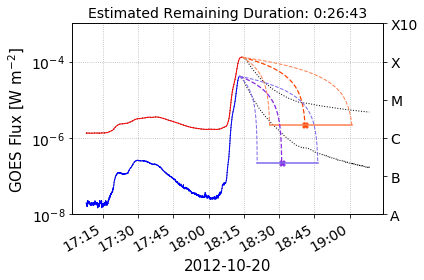

/Users/jreep/anaconda3/lib/python3.7/site-packages/parfive/downloader.py:279: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  position=0)


/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3

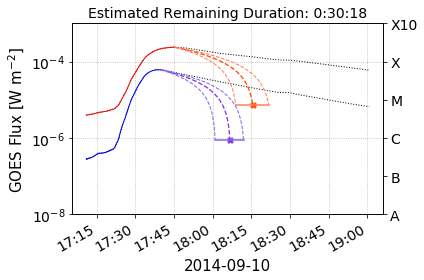

/Users/jreep/anaconda3/lib/python3.7/site-packages/parfive/downloader.py:279: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  position=0)


/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3

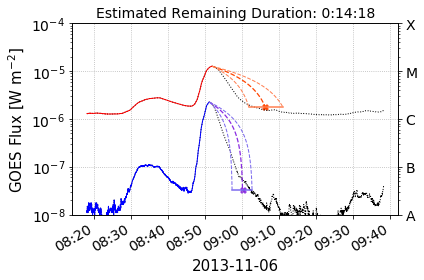

/Users/jreep/anaconda3/lib/python3.7/site-packages/parfive/downloader.py:279: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  position=0)


/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3

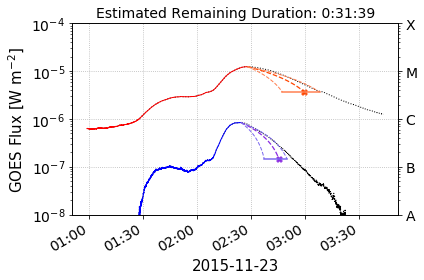

/Users/jreep/anaconda3/lib/python3.7/site-packages/parfive/downloader.py:279: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  position=0)


/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3

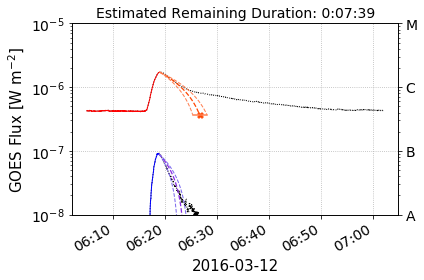

/Users/jreep/anaconda3/lib/python3.7/asyncio/base_events.py:622: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/Users/jreep/anaconda3/lib/python3.7/asyncio/selector_events.py:668: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=76>
  source=self)
/Users/jreep/anaconda3/lib/python3.7/site-packages/parfive/downloader.py:279: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  position=0)


/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3

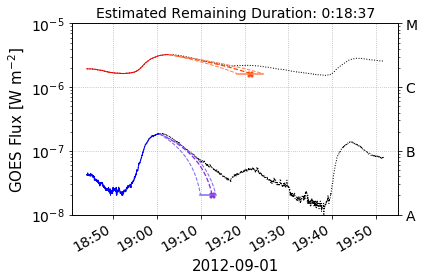

In [15]:
## 2012-10-20 X1.4 flare, short duration.  1-8 A FWHM = 389 s.
predict_and_plot_duration_t2(2002, filename='X_short.eps')

## 2014-09-10 X2.4 flare, long duration.  1-8 A FWHM = 2879 s.
predict_and_plot_duration_t2(2072, filename='X_long.eps')

## 2013-11-06 M1.3 flare, short duration.  1-8 A FWHM = 385 s.
predict_and_plot_duration_t2(2295, filename='M_short.eps')

## 2015-11-23 M1.2 flare, long duration.  1-8 A FHWM = 2488 s.
predict_and_plot_duration_t2(2262, filename='M_long.eps')

## 2016-03-12 C1.7 flare, short duration.  1-8 A FWHM = 442 s.
predict_and_plot_duration_t2(228, filename='C_short.eps')

## 2012-09-01 C3.2 flare, long duration.  1-8 A FWHM = 2551 s.
predict_and_plot_duration_t2(185, filename='C_long.eps')


### Predicting $t_4$ from $t_0,t_1,t_2,t_3$

Now, we do the same starting from time t3 and predicting time t4.  We use the same 6 flares as test cases to see how the predictions change.

In [16]:
# Split data into training and test sets
#  and then train the random forest
## Next train the data using the features through time t3 and make predictions for t4

ind = np.arange(len(data['start_time']))  # This is for selecting out other entries corresponding to the train/test split.
var_names3 = [
    'f0_18', 'f1_18', 'f2_18', 'f3_18', 
    't0_18', 't1_18', 't2_18', 't3_18',
    'a0_18', 'a1_18', 'a2_18', 'a3_18',
    'dfdt0_18', 'dfdt1_18', 'dfdt2_18', 'dfdt3_18',
    'f0_054', 'f1_054', 'f2_054', 'f3_054',
    't0_054', 't1_054', 't2_054', 'f3_054',
    'a0_054', 'a1_054', 'a2_054', 'a3_054',
    'dfdt0_054', 'dfdt1_054', 'dfdt2_054', 'dfdt3_054',
]
features3_t3 = np.array([data[v] for v in var_names3]).T
labels3_t3 = np.array( [data['t4_18'],  data['t4_054']]).T

train_features_t3, test_features_t3, train_labels_t3, test_labels_t3, train_ind_t3, test_ind_t3 \
    = train_test_split(features3_t3, labels3_t3, ind, test_size = 0.33, random_state = 10)


rf_t3 = RandomForestRegressor(n_estimators=1500,max_features='auto',min_samples_leaf=1,min_samples_split=5,max_depth=10,
                          n_jobs=-1)
# Train the model on training data
rf_t3.fit(train_features_t3, train_labels_t3);

# Use the forest's predict method on the test data
predictions_t3 = rf_t3.predict(test_features_t3)

## +-1 and +-2 sigma uncertainties:
err_1s_down_t3, err_1s_up_t3 = pred_ints_vec(rf_t3,test_features_t3)
err_2s_down_t3, err_2s_up_t3 = pred_ints_vec(rf_t3,test_features_t3,percentile=95)



In [17]:
## Define a function to plot and predict the remaining duration for a given event defined by index in the 
##  test set.  Starts at time t3 and runs until t4.
def predict_and_plot_duration_t3(index, filename=None):
    ## First, retrieve the XRS data for the event:
    obs_start = datetime.datetime.strptime( str(data['start_time'][test_ind_t3[index]]), "b'%d-%b-%y %H:%M:%S.%f'")
    obs_end = obs_start + datetime.timedelta(seconds=data['t_e18'][test_ind_t3[index]]+2100)
    timeend = obs_start + datetime.timedelta(seconds=data['t_e18'][test_ind_t3[index]])
    timenow18 = obs_start + datetime.timedelta(seconds=data['t3_18'][test_ind_t3[index]])
    timenow054 = obs_start + datetime.timedelta(seconds=data['t3_054'][test_ind_t3[index]])
    result = Fido.search(a.Time(obs_start, timeend), a.Instrument('xrs')) 
    files = Fido.fetch(result)
    obs_goes = timeseries.TimeSeries(files, concatenate=True) 
    obs_goes = obs_goes.truncate(obs_start, obs_end)
    goes_trunc18 = obs_goes.truncate(obs_start, timenow18)
    goes_trunc054 = obs_goes.truncate(obs_start, timenow054)
    obs_goes_data = obs_goes.to_dataframe()
    goes_trunc_data18 = goes_trunc18.to_dataframe()
    goes_trunc_data054 = goes_trunc054.to_dataframe()

    obs_goes_data['xrsb'] *= scale_xrsb
    obs_goes_data['xrsa'] *= scale_xrsa
    goes_trunc_data18['xrsb'] *= scale_xrsb
    goes_trunc_data054['xrsa'] *= scale_xrsa
    
    ## Create a plot and plot the XRS data up until time t3
    figure = plt.figure()
    axes = plt.gca()
    dates = matplotlib.dates.date2num(parse_time(obs_goes_data.index).datetime)
    dates_trunc18 = matplotlib.dates.date2num(parse_time(goes_trunc_data18.index).datetime)
    dates_trunc054 = matplotlib.dates.date2num(parse_time(goes_trunc_data054.index).datetime)

    axes.plot_date(dates, obs_goes_data['xrsb'], ':',
                       label=r'1.0--8.0 $\AA$', color='black', lw=1)
    axes.plot_date(dates_trunc18, goes_trunc_data18['xrsb'], '-',
                       label=r'1.0--8.0 $\AA$', color='red', lw=1)

    axes.plot_date(dates, obs_goes_data['xrsa'], ':',
                       label=r'0.5--4.0 $\AA$', color='black', lw=1)
    axes.plot_date(dates_trunc054, goes_trunc_data054['xrsa'], '-',
                       label=r'0.5--4.0 $\AA$', color='blue', lw=1)

    ## Plot the predictions for the 1--8 Angstrom channel:
    plt.scatter(obs_start + datetime.timedelta(seconds=predictions_t3[index,0]), data['f0_18'][test_ind_t3[index]],\
             color='orangered', marker='X', lw=0.5)

    pred_t4 = matplotlib.dates.date2num(obs_start + datetime.timedelta(seconds=predictions_t3[index,0]))

    interp_x = np.append(dates_trunc18, pred_t4)
    interp_y = np.append(goes_trunc_data18['xrsb'], data['f0_18'][test_ind_t3[index]])
    interp_f = interp1d(interp_x, interp_y, kind='linear')
    xnew = np.linspace(interp_x[-2], interp_x[-1], num=100, endpoint=True)
    ynew = interp_f(xnew)

    axes.plot_date(xnew, ynew, '--', color='orangered',lw=1.25)
    
    ## Calculate the +- 1 sigma uncertainties in the duration
    pred_t4_1sd = matplotlib.dates.date2num(obs_start + datetime.timedelta(seconds=err_1s_down_t3[index,0]))
    pred_t4_1su = matplotlib.dates.date2num(obs_start + datetime.timedelta(seconds=err_1s_up_t3[index,0]))

    ## Plot interpolated lines connecting t2 to the predicted uncertainties
    interp_x_1sd = np.append(dates_trunc18, pred_t4_1sd)
    interp_f_1sd = interp1d(interp_x_1sd, interp_y, kind='linear')
    x_1sd = np.linspace(interp_x_1sd[-2], interp_x_1sd[-1], num=100, endpoint=True)
    y_1sd = interp_f_1sd(x_1sd)
    axes.plot_date(x_1sd, y_1sd, '--', color='coral',lw=1)

    interp_x_1su = np.append(dates_trunc18, pred_t4_1su)
    interp_f_1su = interp1d(interp_x_1su, interp_y, kind='linear')
    x_1su = np.linspace(interp_x_1su[-2], interp_x_1su[-1], num=100, endpoint=True)
    y_1su = interp_f_1su(x_1su)
    axes.plot_date(x_1su, y_1su, '--', color='coral',lw=1)

    axes.plot_date([pred_t4_1sd,pred_t4_1su],[data['f0_18'][test_ind_t3[index]],
                                              data['f0_18'][test_ind_t3[index]]],'-',color='coral')

    ## Repeat everything for the 0.5--4 A channel
    plt.scatter(obs_start + datetime.timedelta(seconds=predictions_t3[index,1]), data['f0_054'][test_ind_t3[index]],\
             color='blueviolet', marker='X', lw=0.5)

    pred_t4 = matplotlib.dates.date2num(obs_start + datetime.timedelta(seconds=predictions_t3[index,1]))

    interp_x = np.append(dates_trunc054, pred_t4)
    interp_y = np.append(goes_trunc_data054['xrsa'], data['f0_054'][test_ind_t3[index]])
    interp_f = interp1d(interp_x, interp_y, kind='linear')
    xnew = np.linspace(interp_x[-2], interp_x[-1], num=100, endpoint=True)
    ynew = interp_f(xnew)

    axes.plot_date(xnew, ynew, '--', color='blueviolet',lw=1.25)
                    
    pred_t4_1sd = matplotlib.dates.date2num(obs_start + datetime.timedelta(seconds=err_1s_down_t3[index,1]))
    pred_t4_1su = matplotlib.dates.date2num(obs_start + datetime.timedelta(seconds=err_1s_up_t3[index,1]))

    interp_x_1sd = np.append(dates_trunc054, pred_t4_1sd)
    interp_f_1sd = interp1d(interp_x_1sd, interp_y, kind='linear')
    x_1sd = np.linspace(interp_x_1sd[-2], interp_x_1sd[-1], num=100, endpoint=True)
    y_1sd = interp_f_1sd(x_1sd)
    axes.plot_date(x_1sd, y_1sd, '--', color='mediumslateblue',lw=1)

    interp_x_1su = np.append(dates_trunc054, pred_t4_1su)
    interp_f_1su = interp1d(interp_x_1su, interp_y, kind='linear')
    x_1su = np.linspace(interp_x_1su[-2], interp_x_1su[-1], num=100, endpoint=True)
    y_1su = interp_f_1su(x_1su)
    axes.plot_date(x_1su, y_1su, '--', color='mediumslateblue',lw=1)

    axes.plot_date([pred_t4_1sd,pred_t4_1su],[data['f0_054'][test_ind_t3[index]],data['f0_054'][test_ind_t3[index]]],
                   '-',color='mediumslateblue')

    ## clean up the plot:
    plt.grid(True,which='major',axis='both',linestyle=':')
    axes.set_yscale("log")
    if data['f2_18'][test_ind[index]] >= 1e-4:
        axes.set_ylim(1e-8, 1e-3)
    elif data['f2_18'][test_ind[index]] >= 1e-5:
        axes.set_ylim(1e-8, 1e-4)
    elif data['f2_18'][test_ind[index]] >= 1e-6:
        axes.set_ylim(1e-8, 1e-5)
    else:
        axes.set_ylim(1e-8, 1e-6)
    
    axes.set_ylabel('GOES Flux [W m$^{-2}$]',fontsize='15')
    axes.set_xlabel(datetime.datetime.isoformat(obs_goes_data.index[0])[0:10],fontsize='15')

    ax2 = axes.twinx()
    ax2.set_yscale("log")
    if data['f2_18'][test_ind[index]] >= 1e-4:
        ax2.set_ylim(1e-8, 1e-3)
        ax2.set_yticks((1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3 ))
        ax2.set_yticklabels(('A', 'B', 'C', 'M', 'X', 'X10' ),fontsize='14')
    elif data['f2_18'][test_ind[index]] >= 1e-5:
        ax2.set_ylim(1e-8, 1e-4)
        ax2.set_yticks((1e-8, 1e-7, 1e-6, 1e-5, 1e-4 ))
        ax2.set_yticklabels(('A', 'B', 'C', 'M', 'X' ),fontsize='14')
    elif data['f2_18'][test_ind[index]] >= 1e-6:
        ax2.set_ylim(1e-8, 1e-5)
        ax2.set_yticks((1e-8, 1e-7, 1e-6, 1e-5))
        ax2.set_yticklabels(('A', 'B', 'C', 'M' ),fontsize='14')
    else:
        ax2.set_ylim(1e-8, 1e-6)
        ax2.set_yticks((1e-8, 1e-7, 1e-6))
        ax2.set_yticklabels(('A', 'B', 'C' ),fontsize='14')

    remaining = obs_start + datetime.timedelta(seconds=predictions_t3[index,0]) - timenow18
    plt.title('Estimated Remaining Duration: '+str(remaining).split(".")[0],fontsize='14')

    formatter = matplotlib.dates.DateFormatter('%H:%M')
    axes.xaxis.set_major_formatter(formatter)
    axes.fmt_xdata = matplotlib.dates.DateFormatter('%H:%M')
    figure.autofmt_xdate()
    
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename,format='eps',dpi=300)
    plt.show()

Plot the predictions for the same 6 flares as before, now making predictions from time $t_{3}$.

/Users/jreep/anaconda3/lib/python3.7/site-packages/parfive/downloader.py:279: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  position=0)


/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3

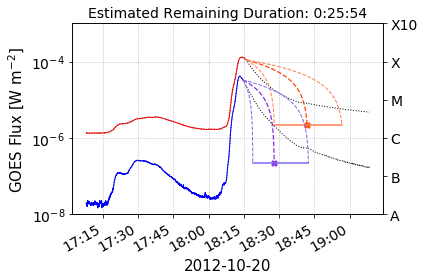

/Users/jreep/anaconda3/lib/python3.7/asyncio/base_events.py:622: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/Users/jreep/anaconda3/lib/python3.7/asyncio/selector_events.py:668: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=81>
  source=self)
/Users/jreep/anaconda3/lib/python3.7/asyncio/base_events.py:622: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/Users/jreep/anaconda3/lib/python3.7/asyncio/selector_events.py:668: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=80>
  source=self)
/Users/jreep/anaconda3/lib/python3.7/site-packages/parfive/downloader.py:279: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  position=0)


/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3

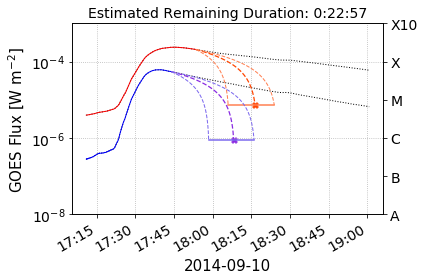

/Users/jreep/anaconda3/lib/python3.7/site-packages/parfive/downloader.py:279: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  position=0)


/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3

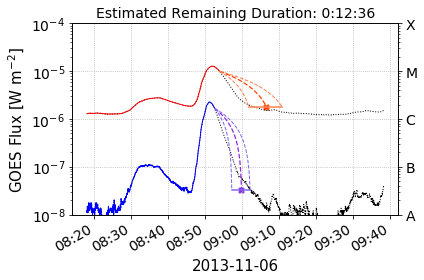

/Users/jreep/anaconda3/lib/python3.7/asyncio/base_events.py:622: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/Users/jreep/anaconda3/lib/python3.7/asyncio/selector_events.py:668: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=85>
  source=self)
/Users/jreep/anaconda3/lib/python3.7/asyncio/base_events.py:622: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/Users/jreep/anaconda3/lib/python3.7/asyncio/selector_events.py:668: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=78>
  source=self)
/Users/jreep/anaconda3/lib/python3.7/site-packages/parfive/downloader.py:279: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  position=0)


/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3

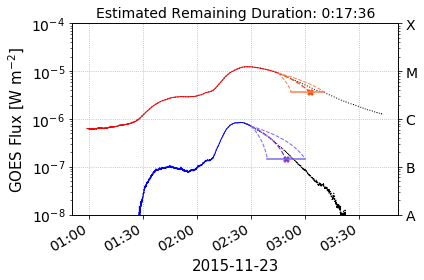

/Users/jreep/anaconda3/lib/python3.7/asyncio/base_events.py:622: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/Users/jreep/anaconda3/lib/python3.7/asyncio/selector_events.py:668: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=86>
  source=self)
/Users/jreep/anaconda3/lib/python3.7/site-packages/parfive/downloader.py:279: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  position=0)


/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3

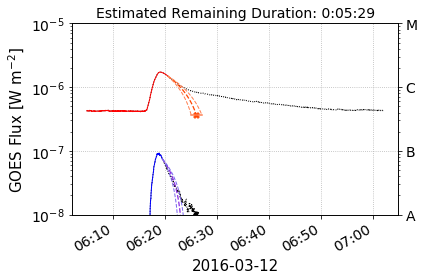

/Users/jreep/anaconda3/lib/python3.7/site-packages/parfive/downloader.py:279: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  position=0)


/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3/lib/python3.7/functools.py:840: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/Users/jreep/anaconda3

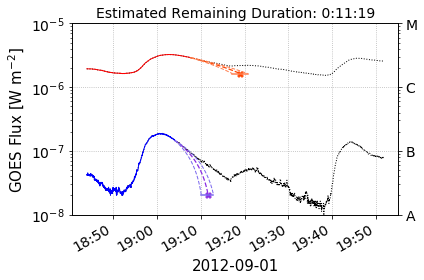

In [18]:
## 2012-10-20 X1.4 flare, short duration.  1-8 A FWHM = 389 s.
predict_and_plot_duration_t3(2002, filename='X_short_t3.eps')

## 2014-09-10 X2.4 flare, long duration.  1-8 A FWHM = 2879 s.
predict_and_plot_duration_t3(2072, filename='X_long_t3.eps')

## 2013-11-06 M1.3 flare, short duration.  1-8 A FWHM = 385 s.
predict_and_plot_duration_t3(2295, filename='M_short_t3.eps')

## 2015-11-23 M1.2 flare, long duration.  1-8 A FHWM = 2488 s.
predict_and_plot_duration_t3(2262, filename='M_long_t3.eps')

## 2016-03-12 C1.7 flare, short duration.  1-8 A FWHM = 442 s.
predict_and_plot_duration_t3(228, filename='C_short_t3.eps')

## 2012-09-01 C3.2 flare, long duration.  1-8 A FWHM = 2551 s.
predict_and_plot_duration_t3(185, filename='C_long_t3.eps')

